In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap("viridis")

import numpy as np
import theano

In [ ]:
from carl.distributions import Join, Mixture, Normal, Exponential, LinearTransform
from sklearn.datasets import make_sparse_spd_matrix

# Parameters
true_A = 1.
true_B = -1.
A = theano.shared(true_A, name="A")
B = theano.shared(true_B, name="B")

# Build simulator
R = make_sparse_spd_matrix(5, alpha=0.5, random_state=7)

p0 = LinearTransform(Join(components=[
        Normal(mu=A, sigma=1),
        Normal(mu=B, sigma=3),
        Mixture(components=[Normal(mu=-2, sigma=1),
                            Normal(mu=2, sigma=0.5)]),
        Exponential(inverse_scale=3.0),
        Exponential(inverse_scale=0.5)]), R)

X_true = p0.rvs(20000) 

In [33]:
# Projection operator
print(R)

[[ 1.31229955  0.10499961  0.48310515 -0.3249938  -0.26387927]
 [ 0.10499961  1.15833058 -0.55865473  0.25275522 -0.39790775]
 [ 0.48310515 -0.55865473  2.25874579 -0.52087938 -0.39271231]
 [-0.3249938   0.25275522 -0.52087938  1.4034925  -0.63521059]
 [-0.26387927 -0.39790775 -0.39271231 -0.63521059  1.        ]]


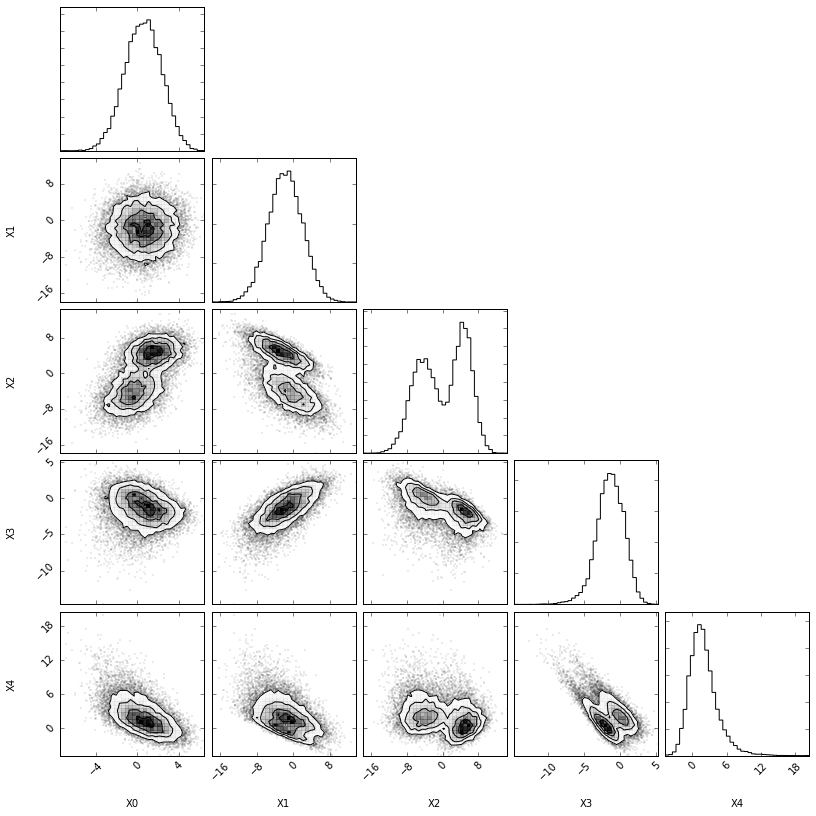

In [3]:
import corner
fig = corner.corner(X_true, bins=40, labels=["X0", "X1", "X2", "X3", "X4"])

In [ ]:
from carl.learning import as_classifier
from carl.learning import make_parameterized_classification
from carl.learning import ParameterizedClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Define p1 at fixed value theta1 := (A=0,B=0)
p1 = LinearTransform(Join(components=[
        Normal(mu=0, sigma=1),
        Normal(mu=0, sigma=3),
        Mixture(components=[Normal(mu=-2, sigma=1),
                            Normal(mu=2, sigma=0.5)]),
        Exponential(inverse_scale=3.0),
        Exponential(inverse_scale=0.5)]), R)

# Build classification data
X, y = make_parameterized_classification(
    p0, p1,
    1000000, 
    [(A, np.linspace(-3, 3, num=30)), 
     (B, np.linspace(-3, 3, num=30))])

# Train parameterized classifier
clf = ParameterizedClassifier(
    make_pipeline(StandardScaler(), 
                  as_classifier(MLPRegressor(learning_rate="adaptive", 
                                             hidden_layer_sizes=(40, 40),
                                             tol=1e-6,
                                             random_state=1))),
    [A, B])
clf.fit(X, y)

In [6]:
from carl.learning import CalibratedClassifierCV
from carl.ratios import ClassifierRatio

def vectorize(func):
    def wrapper(X):
        v = np.zeros(len(X))
        
        for i, x_i in enumerate(X):
            v[i] = func(x_i)
            
        return v.reshape(-1, 1)
    
    return wrapper

def objective(theta, random_state=0): 
    print(theta)
    
    # Set parameter values   
    A.set_value(theta[0])
    B.set_value(theta[1])

    # Fit ratio
    ratio = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf, 
        cv="prefit",  # keep the pre-trained classifier
        method="isotonic"))
    ratio.fit(numerator=p0, denominator=p1, n_samples=10000)

    # Evaluate log-likelihood ratio
    r = ratio.predict(X_true, log=True)
    value = -np.mean(r[np.isfinite(r)])

    return value

In [ ]:
from GPyOpt.methods import BayesianOptimization
solver = BayesianOptimization(vectorize(objective), [(-3, 3), (-3, 3)])
solver.run_optimization(max_iter=50, true_gradients=False)

In [14]:
solver.x_opt

array([ 1.00817153, -1.16896799])

In [22]:
solver.suggested_sample

array([[ 0.94998065, -1.40327593]])

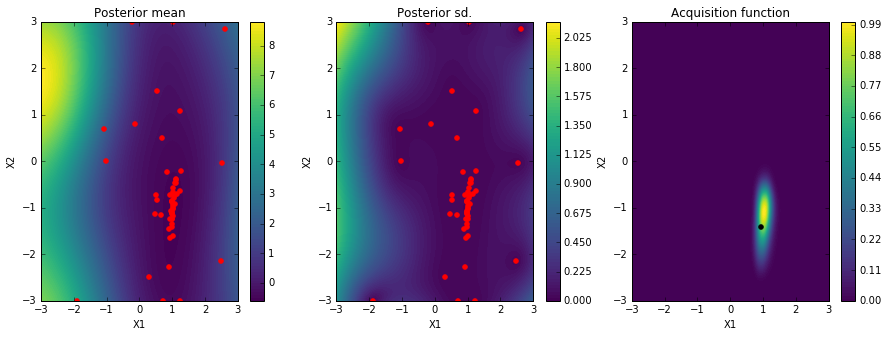

In [17]:
solver.plot_acquisition(filename="fig5.pdf")

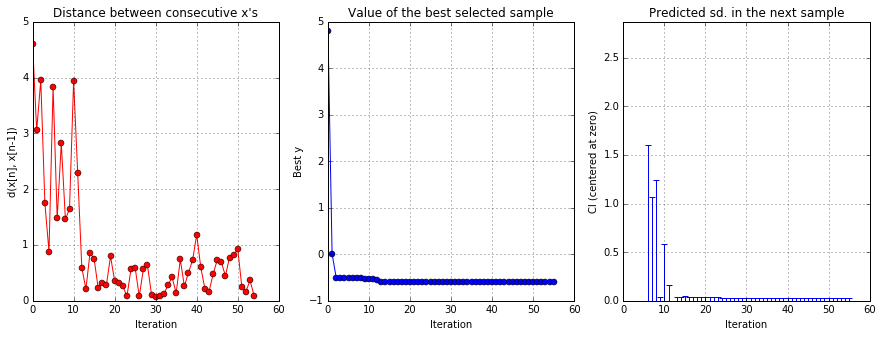

In [69]:
solver.plot_convergence()